In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [19]:
import pandas as pd
df = pd.read_csv("coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")

# add rolling window 2d processor

In [3]:
def rolling_window_2d(a, window):
    nrow, ncol = a.shape
    shape = nrow - window, window, ncol
    strides = a.strides[0], a.strides[0], a.strides[-1]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# create generator for training
I use all of columns for predict the next diff, but data scale is not static, so I standardize it.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime 

## add some constant

In [20]:
columns = ["Open", "High", "Low", "Close", "Volume_(Currency)"]
window = 24
how = {
    "Open": 'first',
    "High": 'max',
    "Low": "min",
    "Close": "last",
    "Volume_(Currency)": 'sum'
}


## set dataframe index to unixtimestamp

In [21]:
df.loc[:, "datetime"] = pd.to_datetime(df["Timestamp"], unit='s')
df = df.set_index("datetime")

## create 60min resolution dataframe

In [22]:
df_60min = df.resample("60min", how=how)
df_train = df_60min[columns]
df_train = df_train.bfill()
diff = df_train.diff()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


## use valid data. (I think 2015~2017 data is not good for predict)

In [23]:
df = diff[datetime(2017, 7, 1):]
df

,Open,High,Low,Close,Volume_(Currency)
datetime,,,,,
2017-07-01 00:00:00,2.19,8.43,6.03,5.84,-1.164132e+06
2017-07-01 01:00:00,5.85,0.90,-11.16,-19.92,1.459702e+05
2017-07-01 02:00:00,-19.95,-25.09,-13.04,-3.24,1.996594e+05
2017-07-01 03:00:00,-2.75,0.91,4.11,-1.76,-4.094932e+05
2017-07-01 04:00:00,-2.23,17.27,-1.34,26.31,-2.574444e+03
...,...,...,...,...,...
2019-01-07 18:00:00,-4.01,3.52,35.72,0.43,-1.021929e+06
2019-01-07 19:00:00,-0.45,-5.52,3.23,8.44,-3.768007e+05
2019-01-07 20:00:00,8.45,1.00,-15.00,-17.28,1.586159e+06


## del nan

In [24]:
diff = df.dropna()
train_diff = diff[:4*len(diff)//6]
valid_diff = diff[4*len(diff)//6:5*len(diff)//6]
test_diff = diff[5*len(diff)//6:]

## create rolling window numpy matrix.

In [25]:
train_diff_rolling_window = rolling_window_2d(a=train_diff.values, window=window)
valid_diff_rolling_window = rolling_window_2d(a=valid_diff.values, window=window)
test_diff_rolling_window = rolling_window_2d(a=test_diff.values, window=window)


## create data generator
Min max normalizing to improve predict

y = close price of next

x = all value

In [26]:
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min)
    return result
    
class MinMaxNormalizer():

  def min_max(self, x, axis=None):
      self.min = x.min(axis=axis, keepdims=True)
      self.max = x.max(axis=axis, keepdims=True)
      result = (x-self.min)/(self.max-self.min)
      return result
    
  def inverse_min_max(self, x, axis=None, index=None):
      return x*(self.max - self.min) + self.min

In [27]:
from torch.utils.data import DataLoader
from scipy import stats
def collate_fn(data):
    winz = np.array(data)
    winz = min_max(winz, axis=1)
    y = winz[:, -1, 3]
    x = winz[:, :-1]
    if cuda:
        return torch.tensor(x, dtype=torch.float32, device='cuda'), torch.tensor(y, dtype=torch.float32, device='cuda')
    else:
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
        
def collate_fn_test(data):
    winz = np.array(data)
    normer = MinMaxNormalizer()
    winz = normer.min_max(winz, axis=1)
    if cuda:
        return torch.tensor(winz, dtype=torch.float32, device='cuda'), normer
    else:
        return torch.tensor(winz, dtype=torch.float32), normer
    

## create GRU network via pytorch 

In [28]:
import torch.nn as nn
from torch import zeros
import torch
from torch import optim
import torch.nn.functional as F
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        

        
    def forward(self, x, h=None):
        out, h = self.gru(x, h)
        out = self.sigmoid(self.fc(self.relu(out[:,-1])))
        return out
    

In [29]:
from tqdm import tqdm_notebook
input_dim = 5
hidden_dim = 128
n_layer = 5  # ONLY CHANGE IS HERE FROM ONE LAYER TO TWO LAYER
output_dim = 1
epoch = 100
batch_size = 32
cuda = True if torch.cuda.is_available() else False
model = GRUNet(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layer, output_dim=output_dim)
loss_function = nn.BCELoss()
optimizer= optim.Adam(model.parameters(), lr=1e-3)
train_data = DataLoader(train_diff_rolling_window , batch_size=batch_size, collate_fn=collate_fn)
valid_data = DataLoader(valid_diff_rolling_window , batch_size=batch_size//4, collate_fn=collate_fn)
data = dict(train=train_data, valid=valid_data)
hidden_tensor = zeros(5, batch_size, hidden_dim)

In [30]:
optimizer= optim.Adam(model.parameters(), lr=1e-3)

# Train gru network

In [31]:
epoch = 100
PATH = "../models/Model_24LSTMwindow.pkl"
print(hidden_tensor.shape)
if cuda:
    model.cuda()
    hidden_tensor = hidden_tensor.float().cuda()
else:
    hidden_tensor = hidden_tensor
hidden = nn.Parameter(hidden_tensor, requires_grad=True)
min_epoch_loss = 1000000

for n in range(epoch):
    print('Epoch {}/{}'.format(n, epoch - 1))
    print('-' * 10)

    for phase in ["train", "valid"]:
        if phase == "train":
            model.train(True)
        else:
            model.train(False)
        epoch_loss = 0
        for x, y in tqdm_notebook(data[phase]):
            model.zero_grad()
            train_outputs = model(x) # batch size x time steps x feature_num
            loss = loss_function(train_outputs, y)
            optimizer.zero_grad()
            if phase == "train":
                loss.backward()
                optimizer.step()
            epoch_loss += loss
        epoch_loss = epoch_loss / len(data[phase])
        
        print('EPOCH: ', str(n), 'phase: ', phase, ' loss :', epoch_loss)
        if phase == "valid" and epoch_loss < min_epoch_loss:
            min_epoch_loss = epoch_loss
            torch.save(model, PATH)
            print(f"saved model to {PATH}")


torch.Size([5, 32, 128])
Epoch 0/99
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



EPOCH:  0 phase:  train  loss : tensor(0.6787, device='cuda:0', grad_fn=<DivBackward0>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)



EPOCH:  0 phase:  valid  loss : tensor(0.6592, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 1/99
----------


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type GRUNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



EPOCH:  1 phase:  train  loss : tensor(0.6687, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  1 phase:  valid  loss : tensor(0.6440, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 2/99
----------



EPOCH:  2 phase:  train  loss : tensor(0.6634, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  2 phase:  valid  loss : tensor(0.6381, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 3/99
----------



EPOCH:  3 phase:  train  loss : tensor(0.6591, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  3 phase:  valid  loss : tensor(0.6402, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4/99
----------



EPOCH:  4 phase:  train  loss : tensor(0.6559, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  4 phase:  valid  loss : tensor(0.6377, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 5/99
----------



EPOCH:  5 phase:  train  loss : tensor(0.6565, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  5 phase:  valid  loss : tensor(0.6477, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6/99
----------



EPOCH:  6 phase:  train  loss : tensor(0.6565, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  6 phase:  valid  loss : tensor(0.6429, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7/99
----------



EPOCH:  7 phase:  train  loss : tensor(0.6556, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  7 phase:  valid  loss : tensor(0.6405, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 8/99
----------



EPOCH:  8 phase:  train  loss : tensor(0.6519, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  8 phase:  valid  loss : tensor(0.6409, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 9/99
----------



EPOCH:  9 phase:  train  loss : tensor(0.6514, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  9 phase:  valid  loss : tensor(0.6413, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 10/99
----------



EPOCH:  10 phase:  train  loss : tensor(0.6534, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  10 phase:  valid  loss : tensor(0.6414, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 11/99
----------



EPOCH:  11 phase:  train  loss : tensor(0.6504, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  11 phase:  valid  loss : tensor(0.6493, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 12/99
----------



EPOCH:  12 phase:  train  loss : tensor(0.6527, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  12 phase:  valid  loss : tensor(0.6375, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 13/99
----------



EPOCH:  13 phase:  train  loss : tensor(0.6530, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  13 phase:  valid  loss : tensor(0.6382, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 14/99
----------



EPOCH:  14 phase:  train  loss : tensor(0.6522, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  14 phase:  valid  loss : tensor(0.6377, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 15/99
----------



EPOCH:  15 phase:  train  loss : tensor(0.6509, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  15 phase:  valid  loss : tensor(0.6349, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 16/99
----------



EPOCH:  16 phase:  train  loss : tensor(0.6552, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  16 phase:  valid  loss : tensor(0.6399, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 17/99
----------



EPOCH:  17 phase:  train  loss : tensor(0.6536, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  17 phase:  valid  loss : tensor(0.6365, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 18/99
----------



EPOCH:  18 phase:  train  loss : tensor(0.6508, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  18 phase:  valid  loss : tensor(0.6319, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 19/99
----------



EPOCH:  19 phase:  train  loss : tensor(0.6498, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  19 phase:  valid  loss : tensor(0.6344, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 20/99
----------



EPOCH:  20 phase:  train  loss : tensor(0.6484, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  20 phase:  valid  loss : tensor(0.6379, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 21/99
----------



EPOCH:  21 phase:  train  loss : tensor(0.6499, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  21 phase:  valid  loss : tensor(0.6374, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 22/99
----------



EPOCH:  22 phase:  train  loss : tensor(0.6482, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  22 phase:  valid  loss : tensor(0.6384, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 23/99
----------



EPOCH:  23 phase:  train  loss : tensor(0.6476, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  23 phase:  valid  loss : tensor(0.6407, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 24/99
----------



EPOCH:  24 phase:  train  loss : tensor(0.6468, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  24 phase:  valid  loss : tensor(0.6374, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 25/99
----------



EPOCH:  25 phase:  train  loss : tensor(0.6475, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  25 phase:  valid  loss : tensor(0.6357, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 26/99
----------



EPOCH:  26 phase:  train  loss : tensor(0.6500, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  26 phase:  valid  loss : tensor(0.6459, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 27/99
----------



EPOCH:  27 phase:  train  loss : tensor(0.6481, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  27 phase:  valid  loss : tensor(0.6346, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 28/99
----------



EPOCH:  28 phase:  train  loss : tensor(0.6465, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  28 phase:  valid  loss : tensor(0.6322, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 29/99
----------



EPOCH:  29 phase:  train  loss : tensor(0.6474, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  29 phase:  valid  loss : tensor(0.6308, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 30/99
----------



EPOCH:  30 phase:  train  loss : tensor(0.6462, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  30 phase:  valid  loss : tensor(0.6246, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 31/99
----------



EPOCH:  31 phase:  train  loss : tensor(0.6459, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  31 phase:  valid  loss : tensor(0.6316, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 32/99
----------



EPOCH:  32 phase:  train  loss : tensor(0.6435, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  32 phase:  valid  loss : tensor(0.6408, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 33/99
----------



EPOCH:  33 phase:  train  loss : tensor(0.6440, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  33 phase:  valid  loss : tensor(0.6416, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 34/99
----------



EPOCH:  34 phase:  train  loss : tensor(0.6457, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  34 phase:  valid  loss : tensor(0.6327, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 35/99
----------



EPOCH:  35 phase:  train  loss : tensor(0.6501, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  35 phase:  valid  loss : tensor(0.6344, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 36/99
----------



EPOCH:  36 phase:  train  loss : tensor(0.6471, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  36 phase:  valid  loss : tensor(0.6217, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 37/99
----------



EPOCH:  37 phase:  train  loss : tensor(0.6450, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  37 phase:  valid  loss : tensor(0.6218, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 38/99
----------



EPOCH:  38 phase:  train  loss : tensor(0.6434, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  38 phase:  valid  loss : tensor(0.6305, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 39/99
----------



EPOCH:  39 phase:  train  loss : tensor(0.6438, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  39 phase:  valid  loss : tensor(0.6344, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 40/99
----------



EPOCH:  40 phase:  train  loss : tensor(0.6435, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  40 phase:  valid  loss : tensor(0.6259, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 41/99
----------



EPOCH:  41 phase:  train  loss : tensor(0.6420, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  41 phase:  valid  loss : tensor(0.6263, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 42/99
----------



EPOCH:  42 phase:  train  loss : tensor(0.6494, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  42 phase:  valid  loss : tensor(0.6220, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 43/99
----------



EPOCH:  43 phase:  train  loss : tensor(0.6439, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  43 phase:  valid  loss : tensor(0.6336, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 44/99
----------



EPOCH:  44 phase:  train  loss : tensor(0.6437, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  44 phase:  valid  loss : tensor(0.6293, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 45/99
----------



EPOCH:  45 phase:  train  loss : tensor(0.6447, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  45 phase:  valid  loss : tensor(0.6260, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 46/99
----------



EPOCH:  46 phase:  train  loss : tensor(0.6419, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  46 phase:  valid  loss : tensor(0.6322, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 47/99
----------



EPOCH:  47 phase:  train  loss : tensor(0.6429, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  47 phase:  valid  loss : tensor(0.6207, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 48/99
----------



EPOCH:  48 phase:  train  loss : tensor(0.6439, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  48 phase:  valid  loss : tensor(0.6279, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 49/99
----------



EPOCH:  49 phase:  train  loss : tensor(0.6431, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  49 phase:  valid  loss : tensor(0.6246, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 50/99
----------



EPOCH:  50 phase:  train  loss : tensor(0.6409, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  50 phase:  valid  loss : tensor(0.6302, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 51/99
----------



EPOCH:  51 phase:  train  loss : tensor(0.6425, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  51 phase:  valid  loss : tensor(0.6281, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 52/99
----------



EPOCH:  52 phase:  train  loss : tensor(0.6447, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  52 phase:  valid  loss : tensor(0.6251, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 53/99
----------



EPOCH:  53 phase:  train  loss : tensor(0.6466, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  53 phase:  valid  loss : tensor(0.6230, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 54/99
----------



EPOCH:  54 phase:  train  loss : tensor(0.6402, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  54 phase:  valid  loss : tensor(0.6280, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 55/99
----------



EPOCH:  55 phase:  train  loss : tensor(0.6464, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  55 phase:  valid  loss : tensor(0.6493, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 56/99
----------



EPOCH:  56 phase:  train  loss : tensor(0.6461, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  56 phase:  valid  loss : tensor(0.6225, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 57/99
----------



EPOCH:  57 phase:  train  loss : tensor(0.6410, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  57 phase:  valid  loss : tensor(0.6296, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 58/99
----------



EPOCH:  58 phase:  train  loss : tensor(0.6389, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  58 phase:  valid  loss : tensor(0.6233, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 59/99
----------



EPOCH:  59 phase:  train  loss : tensor(0.6383, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  59 phase:  valid  loss : tensor(0.6304, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 60/99
----------



EPOCH:  60 phase:  train  loss : tensor(0.6396, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  60 phase:  valid  loss : tensor(0.6264, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 61/99
----------



EPOCH:  61 phase:  train  loss : tensor(0.6457, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  61 phase:  valid  loss : tensor(0.6272, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 62/99
----------



EPOCH:  62 phase:  train  loss : tensor(0.6457, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  62 phase:  valid  loss : tensor(0.6279, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 63/99
----------



EPOCH:  63 phase:  train  loss : tensor(0.6420, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  63 phase:  valid  loss : tensor(0.6247, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 64/99
----------



EPOCH:  64 phase:  train  loss : tensor(0.6388, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  64 phase:  valid  loss : tensor(0.6339, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 65/99
----------



EPOCH:  65 phase:  train  loss : tensor(0.6399, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  65 phase:  valid  loss : tensor(0.6290, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 66/99
----------



EPOCH:  66 phase:  train  loss : tensor(0.6390, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  66 phase:  valid  loss : tensor(0.6321, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 67/99
----------



EPOCH:  67 phase:  train  loss : tensor(0.6419, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  67 phase:  valid  loss : tensor(0.6236, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 68/99
----------



EPOCH:  68 phase:  train  loss : tensor(0.6386, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  68 phase:  valid  loss : tensor(0.6280, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 69/99
----------



EPOCH:  69 phase:  train  loss : tensor(0.6365, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  69 phase:  valid  loss : tensor(0.6424, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 70/99
----------



EPOCH:  70 phase:  train  loss : tensor(0.6467, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  70 phase:  valid  loss : tensor(0.6271, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 71/99
----------



EPOCH:  71 phase:  train  loss : tensor(0.6408, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  71 phase:  valid  loss : tensor(0.6354, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 72/99
----------



EPOCH:  72 phase:  train  loss : tensor(0.6398, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  72 phase:  valid  loss : tensor(0.6290, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 73/99
----------



EPOCH:  73 phase:  train  loss : tensor(0.6369, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  73 phase:  valid  loss : tensor(0.6274, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 74/99
----------



EPOCH:  74 phase:  train  loss : tensor(0.6404, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  74 phase:  valid  loss : tensor(0.6273, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 75/99
----------



EPOCH:  75 phase:  train  loss : tensor(0.6364, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  75 phase:  valid  loss : tensor(0.6398, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 76/99
----------



EPOCH:  76 phase:  train  loss : tensor(0.6431, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  76 phase:  valid  loss : tensor(0.6423, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 77/99
----------



EPOCH:  77 phase:  train  loss : tensor(0.6379, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  77 phase:  valid  loss : tensor(0.6362, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 78/99
----------



EPOCH:  78 phase:  train  loss : tensor(0.6370, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  78 phase:  valid  loss : tensor(0.6369, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 79/99
----------



EPOCH:  79 phase:  train  loss : tensor(0.6385, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  79 phase:  valid  loss : tensor(0.6223, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 80/99
----------



EPOCH:  80 phase:  train  loss : tensor(0.6422, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  80 phase:  valid  loss : tensor(0.6242, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 81/99
----------



EPOCH:  81 phase:  train  loss : tensor(0.6360, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  81 phase:  valid  loss : tensor(0.6344, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 82/99
----------



EPOCH:  82 phase:  train  loss : tensor(0.6360, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  82 phase:  valid  loss : tensor(0.6223, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 83/99
----------



EPOCH:  83 phase:  train  loss : tensor(0.6366, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  83 phase:  valid  loss : tensor(0.6318, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 84/99
----------



EPOCH:  84 phase:  train  loss : tensor(0.6345, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  84 phase:  valid  loss : tensor(0.6269, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 85/99
----------



EPOCH:  85 phase:  train  loss : tensor(0.6335, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  85 phase:  valid  loss : tensor(0.6348, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 86/99
----------



EPOCH:  86 phase:  train  loss : tensor(0.6360, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  86 phase:  valid  loss : tensor(0.6206, device='cuda:0', grad_fn=<DivBackward0>)
saved model to ../models/Model_24LSTMwindow.pkl
Epoch 87/99
----------



EPOCH:  87 phase:  train  loss : tensor(0.6355, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  87 phase:  valid  loss : tensor(0.6349, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 88/99
----------



EPOCH:  88 phase:  train  loss : tensor(0.6333, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  88 phase:  valid  loss : tensor(0.6386, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 89/99
----------



EPOCH:  89 phase:  train  loss : tensor(0.6357, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  89 phase:  valid  loss : tensor(0.6397, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 90/99
----------



EPOCH:  90 phase:  train  loss : tensor(0.6361, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  90 phase:  valid  loss : tensor(0.6436, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 91/99
----------



EPOCH:  91 phase:  train  loss : tensor(0.6338, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  91 phase:  valid  loss : tensor(0.6387, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 92/99
----------



EPOCH:  92 phase:  train  loss : tensor(0.6326, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  92 phase:  valid  loss : tensor(0.6321, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 93/99
----------



EPOCH:  93 phase:  train  loss : tensor(0.6322, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  93 phase:  valid  loss : tensor(0.6385, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 94/99
----------



EPOCH:  94 phase:  train  loss : tensor(0.6333, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  94 phase:  valid  loss : tensor(0.6369, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 95/99
----------



EPOCH:  95 phase:  train  loss : tensor(0.6337, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  95 phase:  valid  loss : tensor(0.6330, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 96/99
----------



EPOCH:  96 phase:  train  loss : tensor(0.6314, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  96 phase:  valid  loss : tensor(0.6340, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 97/99
----------



EPOCH:  97 phase:  train  loss : tensor(0.6322, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  97 phase:  valid  loss : tensor(0.6397, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 98/99
----------



EPOCH:  98 phase:  train  loss : tensor(0.6317, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  98 phase:  valid  loss : tensor(0.6452, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 99/99
----------



EPOCH:  99 phase:  train  loss : tensor(0.6315, device='cuda:0', grad_fn=<DivBackward0>)



EPOCH:  99 phase:  valid  loss : tensor(0.6342, device='cuda:0', grad_fn=<DivBackward0>)


In [33]:
PATH = "../models/Model_24LSTMwindow.pkl"
model = torch.load(PATH)

In [16]:
!pip3 install matplotlib

    100% |████████████████████████████████| 13.1MB 163kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 12.0MB/s ta 0:00:01


In [34]:
import matplotlib.pyplot as plt
test_data = DataLoader(test_diff_rolling_window, batch_size=1, collate_fn=collate_fn_test)

print('-' * 10)

epoch_loss = 0
result = []
ground_truth = []
loss=0
ground_truth_real = []
result_real = []
for winz, normer in test_data:
    x = winz[:, :-1]
    y = winz[:, -1, 3]
    real_data = normer.inverse_min_max(winz.cpu().numpy())
    real_y = real_data[:, -1, 3]
    ground_truth_real.append(real_y)
    train_outputs = model(x) # batch size x time steps x feature_num
    dummy = np.zeros(winz.shape)
    dummy[:, -1, 3] = train_outputs.detach().cpu().numpy()
    real_dummy = normer.inverse_min_max(dummy)
    result_real.append(real_dummy[:, -1, 3] )
    loss = loss_function(train_outputs, y)
    result.append(train_outputs.cpu())
    ground_truth.append(y.cpu())
    epoch_loss += loss
epoch_loss = epoch_loss / len(test_data)
print(' loss :', epoch_loss)


----------
 loss : tensor(0.6057, device='cuda:0', grad_fn=<DivBackward0>)


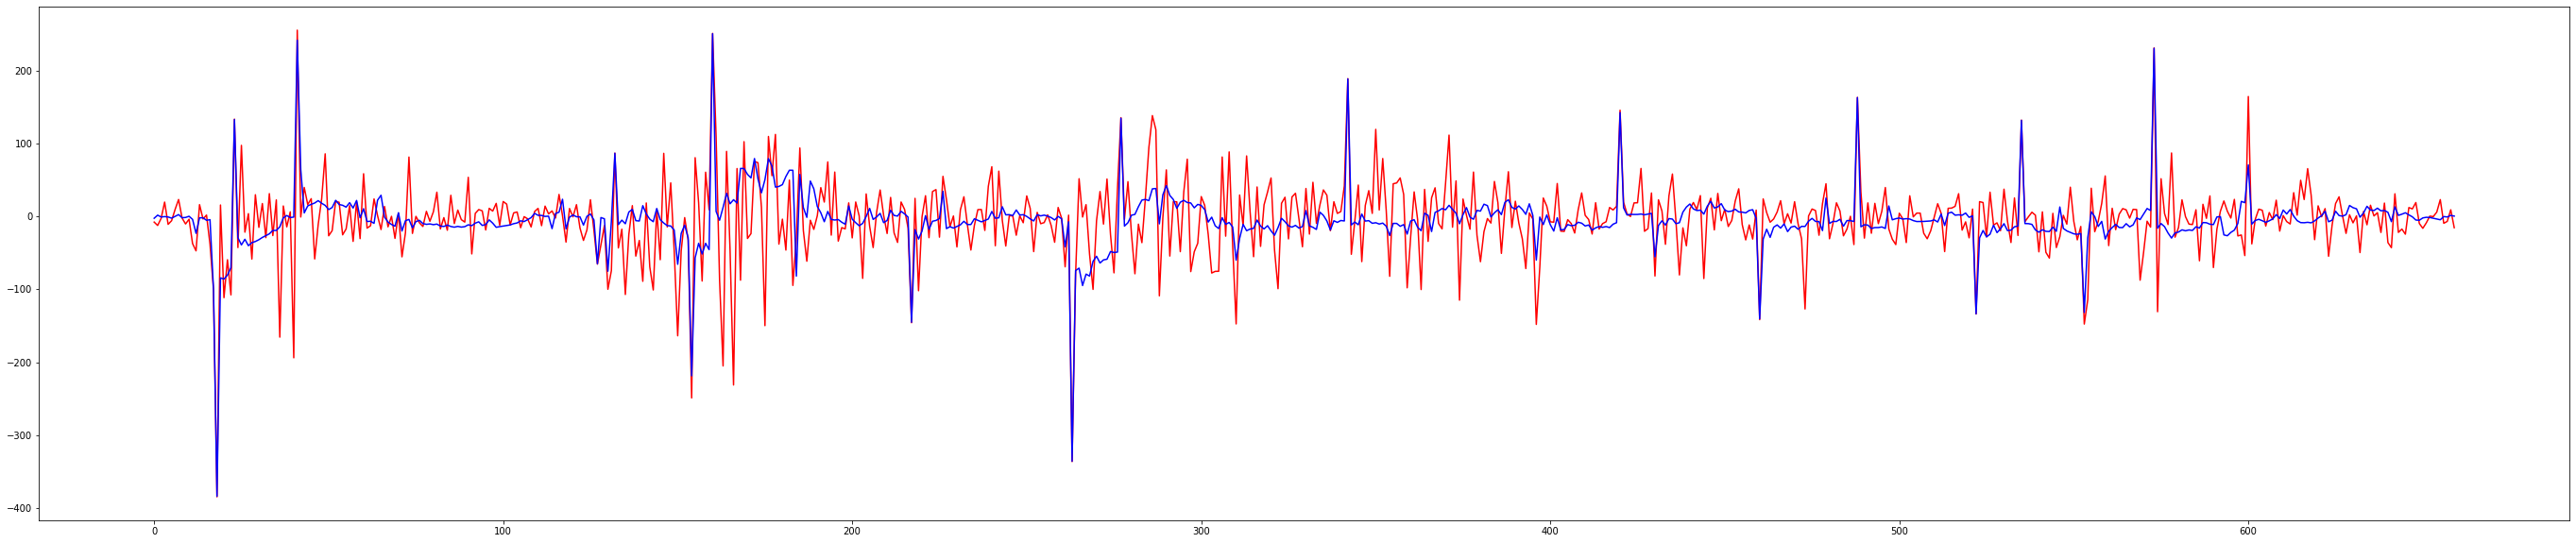

In [35]:
plt.figure(figsize=(48, 10))
plt.plot(ground_truth_real[4*len(ground_truth_real)//10:7*len(result_real)//10], "r")
plt.plot(result_real[4*len(result_real)//10:7*len(result_real)//10], "b")


In [66]:
(np.where(((np.array(ground_truth_real) > 0) & (np.array(result_real) > 0)), 1, 0).sum()  + \
np.where(((np.array(ground_truth_real) <= 0) & (np.array(result_real) <= 0)), 1, 0).sum()) / len(result_real)

0.5679347826086957

In [67]:
gtrnp = np.array(ground_truth_real) 
rrnp = np.array(result_real)

In [68]:
gtrnp_over10 = gtrnp[np.abs(gtrnp) > 10]
rrnp_over10 = rrnp[np.abs(gtrnp) > 10]

In [69]:
(np.where(((gtrnp_over10 > 0) & (rrnp_over10 > 0)), 1, 0).sum()  + \
np.where(((rrnp_over10 <= 0) & (rrnp_over10 <= 0)), 1, 0).sum()) / len(gtrnp_over10)

0.8600191754554171